<a href="https://colab.research.google.com/github/LuuZwide/PO-using-Actor-Critic/blob/main/Model_Project_RRN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U polygon-api-client

In [ ]:
import tensorflow as tf
from google.colab import drive
import pandas as pd
import numpy as np
import math
drive.mount('/content/drive')
import random
from tensorflow import keras
from tensorflow.keras import Model
import math
from datetime import datetime, timedelta
from IPython.core.display import clear_output
import polygon
from polygon import RESTClient
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
n = 7
today = datetime.today()
new_date = today - timedelta(days=n)
formatted_date = new_date.strftime('%Y-%m-%d')
print(formatted_date)

sysdate = today.strftime('%Y-%m-%d')
pdate = today - timedelta(days=n)
pdate = pdate.strftime('%Y-%m-%d')

print('Candlestict date' ,sysdate)
print('indicators date',pdate )

2023-09-18
Candlestict date 2023-09-25
indicators date 2023-09-18


In [ ]:
forex_client = RESTClient('Y_MQfuWV7a5mqIVZeIiB4Y7P4Z9FrpRq')

In [ ]:
mv_response = forex_client.get_sma(ticker = 'C:EURUSD',timespan = 'minute', window = 7, order = 'desc',timestamp_gt= pdate , limit =5000 )

ema_response  = forex_client.get_ema(ticker = 'C:EURUSD',timespan = 'minute', window = 7, order = 'desc',timestamp_gt= pdate, limit =5000)

macd_response = forex_client.get_macd(ticker = 'C:EURUSD',timespan = 'minute',short_window = 12, long_window = 26, signal_window = 9 ,
                                      timestamp_gt= pdate , series_type = 'close', order = 'desc', limit = 5000)


In [ ]:
def convertToDataFrame(mvIndater,valueName):
    ma_list = []
    for indicator_value in mvIndater.values:
        ma_list.append({
            'timestamp': indicator_value.timestamp,
             'value': indicator_value.value,
         })

    ma_df = pd.DataFrame(ma_list)
    #For debugging purposes
    ma_df = ma_df.rename(columns={'value':valueName})
    return ma_df


def convertToDataFrameMACD(macdIndicator):
    macd_list = []
    for indicator_value in macdIndicator.values:
        macd_list.append({
            'timestamp': indicator_value.timestamp,
            'value':indicator_value.value,
            'signal':indicator_value.signal,
            'histogram':indicator_value.histogram,
        })

    macd_df = pd.DataFrame(macd_list)
    #macd = macd_df[['value','signal','histogram']]
    return macd_df

def generateCandleSticks(client, start_date, end_date, limit = 100 ):

    response =  client.get_aggs(ticker = 'C:EURUSD',multiplier = 1,timespan = 'minute',
                                  from_= start_date, to = end_date, sort = 'desc',limit = limit)

    df = pd.DataFrame(response)
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    final_df = df[[ 'open', 'high', 'low', 'close']]
    final_df = final_df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close'})

    return final_df,df


def createChart(candleSticks, ma, ema, macd):

    obj = [candleSticks, ma, ema, macd]
    chart = pd.concat(obj, axis = 1)
    chart = chart.dropna()
    return chart

In [ ]:
candleStick, df = generateCandleSticks(forex_client, start_date = pdate, end_date = sysdate, limit = 5000 )
#candleStick.head()
df.head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc,date
0,1.05965,1.05977,1.0595,1.05976,80,1.0597,1695665760000,80,None,2023-09-25 18:16:00
1,1.05963,1.05969,1.0594,1.05967,82,1.0596,1695665700000,82,None,2023-09-25 18:15:00
2,1.05961,1.05970,1.0594,1.05960,109,1.0596,1695665640000,109,None,2023-09-25 18:14:00
3,1.05968,1.05972,1.0594,1.05961,107,1.0597,1695665580000,107,None,2023-09-25 18:13:00
4,1.05971,1.05973,1.0595,1.05965,74,1.0597,1695665520000,74,None,2023-09-25 18:12:00


In [ ]:
sma = convertToDataFrame(mv_response,'SMA')
sma['date'] = pd.to_datetime(sma['timestamp'], unit='ms')
sma.head()

,timestamp,SMA,date
0,1695665760000,1.059674,2023-09-25 18:16:00
1,1695665700000,1.059667,2023-09-25 18:15:00
2,1695665640000,1.059676,2023-09-25 18:14:00
3,1695665580000,1.059693,2023-09-25 18:13:00
4,1695665520000,1.059709,2023-09-25 18:12:00


In [ ]:
ema = convertToDataFrame(mv_response,'EMA')
ema['date'] = pd.to_datetime(ema['timestamp'], unit='ms')
ema.head()

,timestamp,EMA,date
0,1695665760000,1.059674,2023-09-25 18:16:00
1,1695665700000,1.059667,2023-09-25 18:15:00
2,1695665640000,1.059676,2023-09-25 18:14:00
3,1695665580000,1.059693,2023-09-25 18:13:00
4,1695665520000,1.059709,2023-09-25 18:12:00


In [ ]:
macd = convertToDataFrameMACD(macd_response)
macd['date'] = pd.to_datetime(macd['timestamp'], unit='ms')
macd.head()

,timestamp,value,signal,histogram,date
0,1695665760000,0.000078,0.000090,-0.000012,2023-09-25 18:16:00
1,1695665700000,0.000075,0.000093,-0.000018,2023-09-25 18:15:00
2,1695665640000,0.000079,0.000098,-0.000019,2023-09-25 18:14:00
3,1695665580000,0.000090,0.000102,-0.000012,2023-09-25 18:13:00
4,1695665520000,0.000103,0.000105,-0.000003,2023-09-25 18:12:00


In [ ]:
chart = createChart(candleSticks =candleStick , ma = sma['SMA'], ema = ema['EMA'], macd = macd[['value',	'signal',	'histogram']])
chart.head(10)

,Open,High,Low,Close,SMA,EMA,value,signal,histogram
0,1.05965,1.05977,1.0595,1.05976,1.059674,1.059674,0.000078,0.000090,-0.000012
1,1.05963,1.05969,1.0594,1.05967,1.059667,1.059667,0.000075,0.000093,-0.000018
2,1.05961,1.05970,1.0594,1.05960,1.059676,1.059676,0.000079,0.000098,-0.000019
3,1.05968,1.05972,1.0594,1.05961,1.059693,1.059693,0.000090,0.000102,-0.000012
4,1.05971,1.05973,1.0595,1.05965,1.059709,1.059709,0.000103,0.000105,-0.000003
5,1.05971,1.05980,1.0595,1.05973,1.059740,1.059740,0.000113,0.000106,0.000006
6,1.05973,1.05980,1.0596,1.05970,1.059750,1.059750,0.000115,0.000105,0.000011
7,1.05972,1.05980,1.0595,1.05971,1.059721,1.059721,0.000121,0.000102,0.000019
8,1.05971,1.05980,1.0595,1.05973,1.059711,1.059711,0.000124,0.000097,0.000027
9,1.05973,1.05973,1.0595,1.05972,1.059709,1.059709,0.000125,0.000090,0.000035


In [ ]:


def convertToSequence(chart,timeSteps,closes):
  rnnChart = chart.values
  input_sequences = []
  target_sequences = []

  for i in range(len(rnnChart) - timeSteps):
    input_sequences.append(rnnChart[i:i+timeSteps])
    target_sequences.append(closes[i+timeSteps -1 ])

  input= np.array(input_sequences)
  target= np.array(target_sequences)

  return input, target

In [ ]:
class ReplayBuffer():
  def __init__(self, max_size, input_shape, num_actions):
    self.max_size = max_size
    self.input_shape = input_shape
    self.num_actions = num_actions
    self.state_memory = np.zeros((self.max_size, input_shape))
    self.action_memory = np.zeros((self.max_size, num_actions))
    self.reward_memory = np.zeros(self.max_size)
    self.next_state_memory = np.zeros((self.max_size, input_shape))
    self.terminal_memory= np.zeros(self.max_size, dtype = np.float32)
    self.mem_counter = 1

  def store_transitions(self,state, action, reward, done):
    index = self.mem_counter % self.max_size
    self.state_memory[index] = state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done) #False = 0 , True = 1 Cause if the state is done G will 0 cause the are no future rewards
    if self.mem_counter > 0 :
      self.next_state_memory[index - 1] = state

    self.mem_counter += 1

  def sample(self, batch_size):
    start_range = min(self.mem_counter, self.max_size)
    start_index = random.randint(0, start_range - batch_size)
    end_index = start_index + batch_size

    states = self.state_memory[start_index : end_index]
    actions = self.action_memory[start_index : end_index]
    rewards = self.reward_memory[start_index : end_index]
    next_states = self.next_state_memory[start_index : end_index]
    dones = self.terminal_memory[start_index : end_index]

    return states, actions, rewards, next_states,dones

  def back_sample(self, batch_size):
    start_index = 0
    end_index = batch_size

    states = self.state_memory[start_index : end_index]
    actions = self.action_memory[start_index : end_index]
    rewards = self.reward_memory[start_index : end_index]
    next_states = self.next_state_memory[start_index : end_index]
    dones = self.terminal_memory[start_index : end_index]

    return states, actions, rewards, next_states,dones

  def random_sample(self, batch_size):
    mem_size = min(self.mem_counter, self.max_size)
    batch = np.random.choice(mem_size, batch_size)

    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    next_states = self.next_state_memory[batch]
    dones = self.terminal_memory[batch]

    return states, actions, rewards, next_states,dones

  def clear_memory(self):
    self.state_memory = np.zeros((self.max_size, self.input_shape))
    self.action_memory = np.zeros((self.max_size, self.num_actions))
    self.reward_memory = np.zeros(self.max_size)
    self.next_state_memory = np.zeros((self.max_size, self.input_shape))
    self.terminal_memory= np.zeros(self.max_size, dtype = np.float32)
    self.mem_counter = 1



In [ ]:
class Portfolio():
    def __init__(self, starting_amount):
        self.port_value = starting_amount
        self.prev_port_value = starting_amount
        self.starting_amount = starting_amount
        self.transactionCost = starting_amount * 0.003
        self.relative_vector = None
        self.prev_relative_vector = np.array([0, 0])
        self.prev_weights = np.array([0, 0])
        self.hold_weight = 0.0005
        self.returns = []
        self.counter = 0

    def update_port(self, weights, prev_prices, cur_prices):
        prev = np.hstack(([1], prev_prices))
        curr = np.hstack(([1], cur_prices))
        self.relative_vector = curr / prev

        self.prev_weights = weights

        return

    def calculate_reward(self, weights):

        rateReturn = np.dot(self.relative_vector, np.array((0,1)))
        rateReturn =  math.log(rateReturn)

        self.counter += 1
        reward = rateReturn
        self.prev_weights = weights
        return reward


    def clear_returns(self):
        self.returns = []
        self.counter = 0

In [ ]:
class Env():

  def __init__(self, Portfolio, chart , closing_amounts, episode_length ): #add a model to my parameters
    self.chart = chart
    self.closing_amounts = closing_amounts
    self.portfolio = Portfolio
    self.episode_length = episode_length
    self.index = 0
    self.counter = 0 # Count the number of days the agent have been trading
    self.done = False
    self.trunc = False
    self.starting_amount = Portfolio.starting_amount
    self.trade_count = 0 # Number of times the agent has traded
    self.prev_porfolio_value = self.portfolio.port_value
    self.current_portfolio_value = self.portfolio.port_value
    self.returns = 0

  def reset(self): # Index is to deside when to start the trading period

    self.portfolio = Portfolio(self.starting_amount)
    self.index = random.randint(0, len(self.chart) - self.episode_length )
    initial_weights = np.array([1, 0])
    self.counter = 0
    self.portfolio.prev_weights = [0,0]
    self.portfolio.clear_returns()
    self.state = self.add_gaussian_noise(self.chart[self.index])
    return self.state

  def add_gaussian_noise(self, state, mean = 0.0, std_dev = 0.00001):
    noise = np.random.normal(mean, std_dev, size=state.shape)
    noisy_state = state + noise
    return noisy_state

  def check_done(self, portfolio_value):
    done = False
    threshhold =  portfolio_value/self.starting_amount
    if threshhold > 0.01:
      done = False
    else:
      done = True
    return done

  def check_trunc(self):
    if(self.counter > self.episode_length):
      return True
    else:
      return False

  def step(self, action ):

    if ((self.index + 1) < len(self.chart)):
      prev_closing = self.closing_amounts[self.index]
      cur_closing = self.closing_amounts[self.index + 1]
      self.prev_prev_porfolio_value = self.current_portfolio_value
      self.portfolio.update_port(action, prev_closing, cur_closing)
      reward = self.portfolio.calculate_reward( action)
      next_state = self.chart[self.index]
      done = False
      trunc = False
    else:
      next_state = self.chart[self.index]
      done = True
      reward = 0
      trunc = True

    if(self.check_done(self.current_portfolio_value)) is True:
      done = True
      next_state = self.chart[self.index]
      reward = reward
      trunc = False

    if(self.check_trunc() is True):
      trunc = True
      done = False
      reward = reward
      next_state = self.chart[self.index]



    self.counter = self.counter + 1
    self.next_state =  self.add_gaussian_noise(next_state)
    self.reward = reward
    self.done = done
    self.trunc = trunc
    self.index = self.index + 1

    return self.next_state, self.reward, self.done, self.trunc

In [ ]:
class Preprocessor():
  def __init__(self):
    self.normLayer = keras.layers.Normalization(axis = -1)

  def adaptNorm(self,x):
    self.normLayer.adapt(x)

  def getPreprocessor(self):
    return  self.normLayer

In [ ]:
class PreprocessingModel(tf.keras.Model):
    def __init__(self,features):
        super(PreprocessingModel, self).__init__()

        self.input_layer = keras.layers.InputLayer(input_shape=(features,))
        self.normalisation_layer = keras.layers.Normalization(axis=-1)

    def call(self, state):
        x = self.input_layer(state)
        out = self.normalisation_layer(x)
        return out

In [ ]:
class Actor():
  def __init__(self,features, preprocessor, learningRate):
    self.features = features
    self.preprocessor = preprocessor
    self.learningRate = learningRate
    self.timesteps = 1

  def buildModel(self):
    model = keras.Sequential(name = "Actor_Model")
    model.add(keras.layers.InputLayer(input_shape=(self.features, )))
    model.add(self.preprocessor.getPreprocessor())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile( optimizer = keras.optimizers.Adam(learning_rate = self.learningRate))

    return model

In [ ]:
class Dummy():
  def __init__(self,features, preprocessor, learningRate):
    self.features = features
    self.preprocessor = preprocessor
    self.learningRate = learningRate
    self.timesteps = 1

  def buildModel(self):
    model = keras.Sequential(name = "dummyActor")
    model.add(keras.layers.InputLayer(input_shape=(self.features  + 2, )))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(1))

    model.compile( optimizer = keras.optimizers.Adam(learning_rate = self.learningRate))

    return model

In [ ]:
class Critic():
  def __init__(self, timesteps, features, learningRate):
    self.timesteps = timesteps
    self.features = features
    self.learningRate = learningRate

  def buildModel(self):
    model = keras.Sequential(name = "Critic_Model")
    model.add(keras.layers.InputLayer(input_shape=(self.timesteps, self.features + 2)))
    model.add(keras.layers.LSTM(units=256, activation='tanh', return_sequences=True))
    model.add(keras.layers.LSTM(units=256, activation='tanh', return_sequences=False))
    model.add(keras.layers.Dense(1))

    model.compile( optimizer = keras.optimizers.Adam(learning_rate = self.learningRate))

    return model

In [ ]:
class Agent():
  def __init__(self, memory , actor_model,critic_model, dummyCritic , preprocessor,  batch_size, save_location ,gamma = 0,num_batches = 1):
    self.num_batches = num_batches
    self.features = features
    self.timesteps = 40
    self.gamma = gamma
    self.batch_size = batch_size

    self.Actor = actor_model
    self.Critic = critic_model
    self.dummyCritic = dummyCritic

    self.memory = memory
    self.learn_counter  = 0
    self.preprocessor = preprocessor

    self.save_location = save_location
    self.act_loc = self.save_location + 'actor'
    self.cri_loc = self.save_location + 'critic'

  def ConvertToLSTMInput(self, states,actions,rewards):
    concatenated_state = np.concatenate((states, actions), axis = 1)
    input_sequences = []
    target_sequences = []
    timeSteps = self.timesteps

    for i in range(len(states) - timeSteps):
      input_sequences.append(concatenated_state[i:i+timeSteps])
      target_sequences.append(rewards[i + timeSteps- 1])

    input= np.array(input_sequences)
    target= np.array(target_sequences)

    return input, target

  def choose_action(self, state):
    weights = self.Actor(state)
    action = weights.numpy()[0]
    return action

  def update_memory(self,state, action, reward, done):
    self.memory.store_transitions(state, action , reward, done)

  def save_models(self):
    print('...saving models...')
    self.Actor.save(self.act_loc)
    self.Critic.save(self.cri_loc)

  def load_models(self):
    print('...load model....')
    self.Actor = keras.models.load_model(self.act_loc)
    self.Critic = keras.models.load_model(self.cri_loc)

  def learn(self, step):

    if (self.memory.mem_counter < self.batch_size +  self.timesteps + 10 ) :
      return 0, 0
    else:
      self.learn_counter += 1
      states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size +  self.timesteps )
      actions = tf.cast(actions, dtype=tf.float32)

      pstates = self.preprocessor(states)

      criticStates, critic_rewards = self.ConvertToLSTMInput(pstates, actions,rewards )

      with tf.GradientTape() as tape:
        y = tf.cast(tf.expand_dims(critic_rewards, axis=-1), dtype=tf.float32)
        value_func = self.Critic(criticStates)
        critic_loss = tf.losses.mean_squared_error(y, value_func)
        critic_loss = tf.reduce_mean(critic_loss)

      critic_gradients = tape.gradient(critic_loss, self.Critic.trainable_variables)
      self.Critic.optimizer.apply_gradients(zip(critic_gradients, self.Critic.trainable_variables))

      current_actions = self.Actor(states)
      critic_states, _ = self.ConvertToLSTMInput(pstates, current_actions, rewards )
      loss = self.Critic(critic_states)
      loss = tf.reduce_mean(loss)

      with tf.GradientTape() as tape:
        current_actions = self.Actor(states)
        actor_loss = self.dummyCritic(tf.concat([states,current_actions],axis = 1))
        actor_loss =  tf.reduce_mean(actor_loss) * 0 -1*loss

      actor_gradients = tape.gradient(actor_loss, self.Actor.trainable_variables)
      self.Actor.optimizer.apply_gradients(zip(actor_gradients, self.Actor.trainable_variables))

    return actor_loss, critic_loss

In [ ]:
#Hyperparameters
max_size = 20000
learning_rate = 1e-8
timesteps = 40
critic_lr  = 0.00005
episode_length = 120
starting_amount = 200
batch_size = 64
num_episodes = 500

#Data
# Xchart, ychart = convertToSequence(chart,timesteps,chart['Close'])
# _, timesteps, features = Xchart.shape
Xchart = chart.values
ychart = chart['Close'].values
_, features = chart.shape

#Portfolio
portfolio =  Portfolio(starting_amount = starting_amount)

#Env
env = Env(portfolio, Xchart, ychart , episode_length = episode_length)

#Memory
replayBuffer = ReplayBuffer(max_size, 9,2)

#Preprocessor
Critic_preprocessor = PreprocessingModel(features = features)

#Actor Preprocessor
preprocessor = Preprocessor()

#Adapt the preprocessing layers
Critic_preprocessor.normalisation_layer.adapt(Xchart)
preprocessor.adaptNorm(Xchart)


#Models
actor = Actor( features = features, preprocessor = preprocessor, learningRate = learning_rate)
dummyCritic = Dummy( features = features, preprocessor = preprocessor, learningRate = learning_rate)
critic = Critic(timesteps = timesteps, features =features , learningRate = critic_lr)

critic_model = critic.buildModel()
actor_model = actor.buildModel()
dummyCritic = dummyCritic.buildModel()

actor_model.summary()
critic_model.summary()
actor_model.build()

#Saved location
save_location = '/content/drive/MyDrive/Models/RNN Models/ACCost/'

#Agent
agent = Agent( memory  = replayBuffer , actor_model = actor_model,critic_model = critic_model ,dummyCritic=dummyCritic, preprocessor = Critic_preprocessor,
              batch_size = batch_size, save_location = save_location)


avg_scores = []
avg_rewards = []
avg_reward_history = []
scores = 0
rewards = 0
score_history = []
reward_history = []
actor_loss_history = []
critic_loss_history = []
actor_avg_lesses = []
critic_avg_lesses = []
high_score = -1
loopSize = 1
step = 0

Model: "Actor_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_29 (Dense)            (None, 256)               2560      
                                                                 
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dense_31 (Dense)            (None, 2)                 514       
                                                                 
Total params: 68885 (269.09 KB)
Trainable params: 68866 (269.01 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________
Model: "Critic_Model"
___________________________________________________________

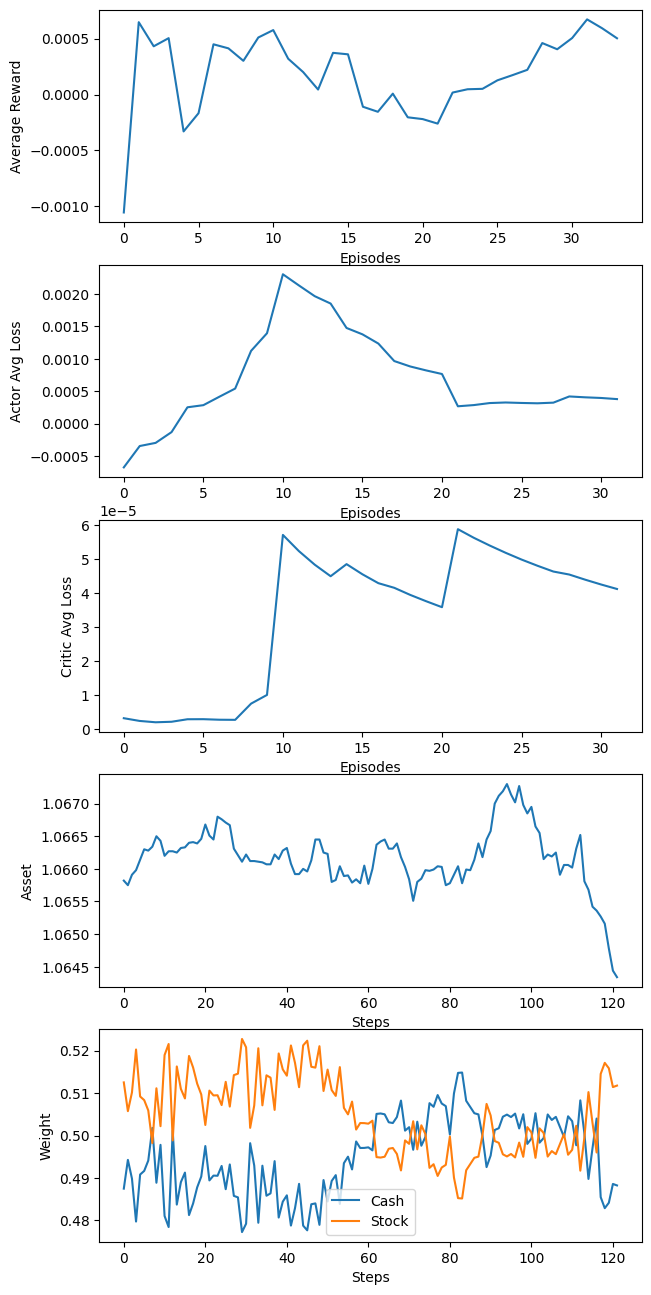

episode:  34


KeyboardInterrupt: ignored

In [ ]:
for e in range(num_episodes):
    weights_history = []
    highest = 0
    state = env.reset()
    rewards = 0
    done, trunc = (False, False)
    starting_index = env.index
    print('episode: ', e)
    while not (trunc):
        actor_state = np.expand_dims(state, axis = 0)
        action = agent.choose_action(actor_state)
        step += 1
        next_state, reward, done, trunc = env.step(action)
        rewards += reward
        agent.update_memory(state, action, reward, done)
        if (step % 4 == 0):
          for i in range(16):
            actor_loss,critic_loss  =  agent.learn(step)
        state = next_state
        weights_history.append(action)

    avg_reward_history.append(rewards)
    avg_reward = np.mean(avg_reward_history[-10:])
    avg_rewards.append(avg_reward)


    if (avg_reward > high_score) & (e > 10) :
      high_score = avg_reward
      agent.save_models()


    if e > 1 :
      actor_loss_history.append(actor_loss)
      avg_loss = np.mean(actor_loss_history)
      actor_avg_lesses.append(avg_loss)

      critic_loss_history.append(critic_loss)
      avg_loss = np.mean(critic_loss_history)
      critic_avg_lesses.append(avg_loss)

    if  e > 10:
        clear_output(wait=True)
        fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(7, 16))
        ax[0].plot(avg_rewards)
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Average Reward')

        ax[1].plot(actor_avg_lesses)
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Actor Avg Loss')

        ax[2].plot(critic_avg_lesses)
        ax[2].set_xlabel('Episodes')
        ax[2].set_ylabel('Critic Avg Loss')

        ax[3].plot(ychart[starting_index:env.index])
        ax[3].set_xlabel('Steps')
        ax[3].set_ylabel('Asset')

        ax[4].plot(weights_history)
        ax[4].set_xlabel('Steps')
        ax[4].set_ylabel('Weight')
        ax[4].legend(['Cash', 'Stock'])

        plt.show()

In [ ]:
print(weights_history)

In [ ]:
agent.save_models()